In [ ]:
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from pymatgen.core import Composition
from sklearn.metrics import mean_absolute_error, r2_score

InteractiveShell.instance().ast_node_interactivity = "all"

In [2]:
preprocessing_objects = joblib.load("data/preprocessing_objects_20250615.pkl.z")
all_data = pd.read_parquet("data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet")
all_data = all_data.loc[~all_data.index.isin(preprocessing_objects["dropped_idx"])]
all_data.composition = all_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)


.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Us

In [4]:
props = [
    "Thermal conductivity",  # 0
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
]

for prop_name in props:
    print(f"Processing property: {prop_name}")
    # 定义 prediction 文件夹路径
    prediction_dir = Path(f"notebooks/logs/kernel_regression/{prop_name}")

    prop_idx = all_data[prop_name].dropna().index
    prop_T = (
        all_data[f"{prop_name} (T/K)"].loc[prop_idx]
        if prop_name != "DOS density"
        else all_data["DOS energy"].loc[prop_idx]
    )

    if prop_name == "Thermal conductivity":
        OUTLIER = 1400
    elif prop_name == "Seebeck coefficient":
        OUTLIER = 1500
    else:
        OUTLIER = None

    if OUTLIER is not None and OUTLIER:
        # Remove entries where any value in prop_T > 270 (remove whole sample if any t > 270)
        mask = prop_T.apply(lambda arr: np.all(np.asarray(arr) <= OUTLIER))
        prop_idx = prop_idx[mask]
        prop_T = prop_T[mask]

    test_idx = all_data[all_data["split"] == "test"].index
    prop_test_idx = test_idx.intersection(prop_idx)

    tmp = all_data.loc[prop_test_idx, ["Material type"]]
    mask_not_others = tmp["Material type"] != "others"
    hm_test_idx = prop_test_idx[mask_not_others]

    # # 用于存储所有 trial 的 metrics
    metrics_list = []

    for result_dir in prediction_dir.iterdir():
        if result_dir.is_dir() and result_dir.name not in [".ipynb_checkpoints", "summary"]:
            nk, ratio = result_dir.name.split("_")[-2:]
            nk, ratio = int(nk[2:]), float(ratio[1:])
            for pred_dir in (result_dir / "predictions").iterdir():
                if pred_dir.is_dir() and pred_dir.name.startswith("trial_"):
                    n_trial = int(pred_dir.name.split("_")[-1])
                    result_path = pred_dir / "results.csv"
                    if result_path.exists():
                        df = pd.read_csv(result_path)
                        df = df[df.label == "prediction"]
                        t = df.t.values.reshape(-1, 300)[mask_not_others].flatten()
                        y_true = df.ture.values.reshape(-1, 300)[mask_not_others].flatten()
                        y_pred = df.prediction.values.reshape(-1, 300)[mask_not_others].flatten()
                        if y_true.size == 0 or y_pred.size == 0:
                            print(f"No HM test data for {prop_name} in {pred_dir}")
                            continue
                        df = pd.DataFrame(
                            {
                                "ture": y_true,
                                "prediction": y_pred,
                                "t": t,
                                "label": "prediction",
                            }
                        )
                        df.to_csv(pred_dir / "hm_results.csv", index=False)
                        df.to_parquet(pred_dir / "hm_results.parquet", index=False)
                        _ = joblib.dump(hm_test_idx.to_list(), pred_dir / "hm_test_idx.pkl.z")
                        mae = mean_absolute_error(y_true, y_pred)
                        r2 = r2_score(y_true, y_pred)
                        metrics = {"mae": float(mae), "r2": float(r2)}
                        with open(pred_dir / "hm_metrics.json", "w") as f:
                            json.dump(metrics, f, indent=2)


Processing property: Thermal conductivity
Processing property: Power factor
Processing property: Seebeck coefficient
Processing property: ZT
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_1
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_2
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_3
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_4
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_5
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_6
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_7
No HM test data for ZT in notebooks/logs/kernel_regression/ZT/0903_0024_nk10_r0.9/predictions/trial_8
No HM test data for ZT in notebooks/logs/ke

Processing property: Thermal conductivity
Total metrics collected: 1 for Thermal conductivity so far with ratio 1.0 and trial 1
Total metrics collected: 2 for Thermal conductivity so far with ratio 1.0 and trial 2
Total metrics collected: 3 for Thermal conductivity so far with ratio 1.0 and trial 3
Total metrics collected: 4 for Thermal conductivity so far with ratio 1.0 and trial 4
Total metrics collected: 5 for Thermal conductivity so far with ratio 1.0 and trial 5
Total metrics collected: 6 for Thermal conductivity so far with ratio 1.0 and trial 6
Total metrics collected: 7 for Thermal conductivity so far with ratio 1.0 and trial 7
Total metrics collected: 8 for Thermal conductivity so far with ratio 1.0 and trial 8
Total metrics collected: 9 for Thermal conductivity so far with ratio 1.0 and trial 9
Total metrics collected: 10 for Thermal conductivity so far with ratio 1.0 and trial 10
Total metrics collected: 11 for Thermal conductivity so far with ratio 1.0 and trial 11
Total me

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, 'MAE')

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, '$R^2$')

Text(0.5, 0.95, 'Thermal conductivity (HM; normalized)')

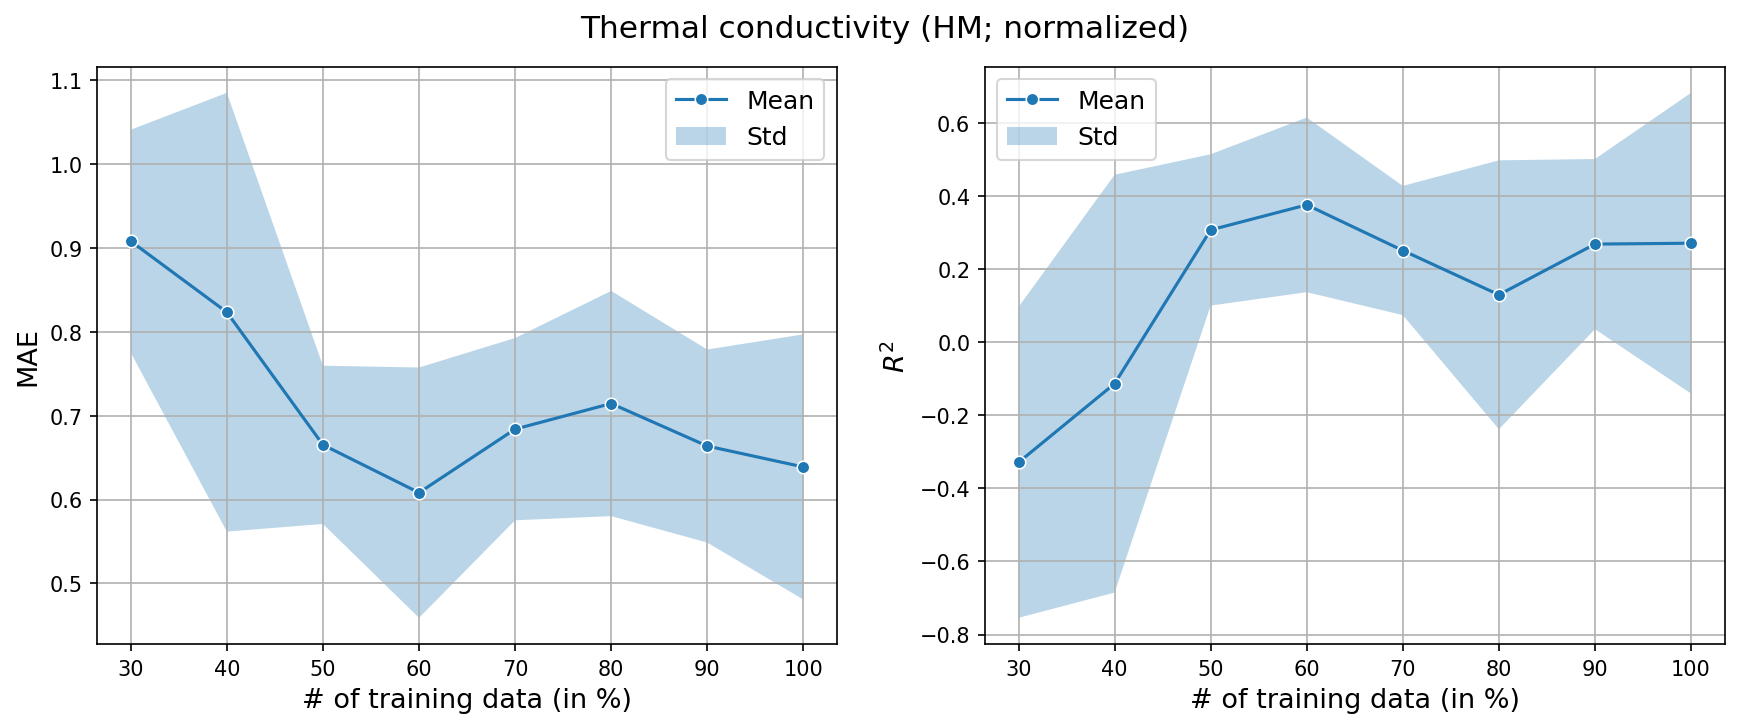

Processing property: Power factor
Total metrics collected: 1 for Power factor so far with ratio 0.9 and trial 1
Total metrics collected: 2 for Power factor so far with ratio 0.9 and trial 2
Total metrics collected: 3 for Power factor so far with ratio 0.9 and trial 3
Total metrics collected: 4 for Power factor so far with ratio 0.9 and trial 4
Total metrics collected: 5 for Power factor so far with ratio 0.9 and trial 5
Total metrics collected: 6 for Power factor so far with ratio 0.9 and trial 6
Total metrics collected: 7 for Power factor so far with ratio 0.9 and trial 7
Total metrics collected: 8 for Power factor so far with ratio 0.9 and trial 8
Total metrics collected: 9 for Power factor so far with ratio 0.9 and trial 9
Total metrics collected: 10 for Power factor so far with ratio 0.9 and trial 10
Total metrics collected: 11 for Power factor so far with ratio 0.9 and trial 11
Total metrics collected: 12 for Power factor so far with ratio 0.9 and trial 12
Total metrics collected:

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, 'MAE')

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, '$R^2$')

Text(0.5, 0.95, 'Power factor (HM; normalized)')

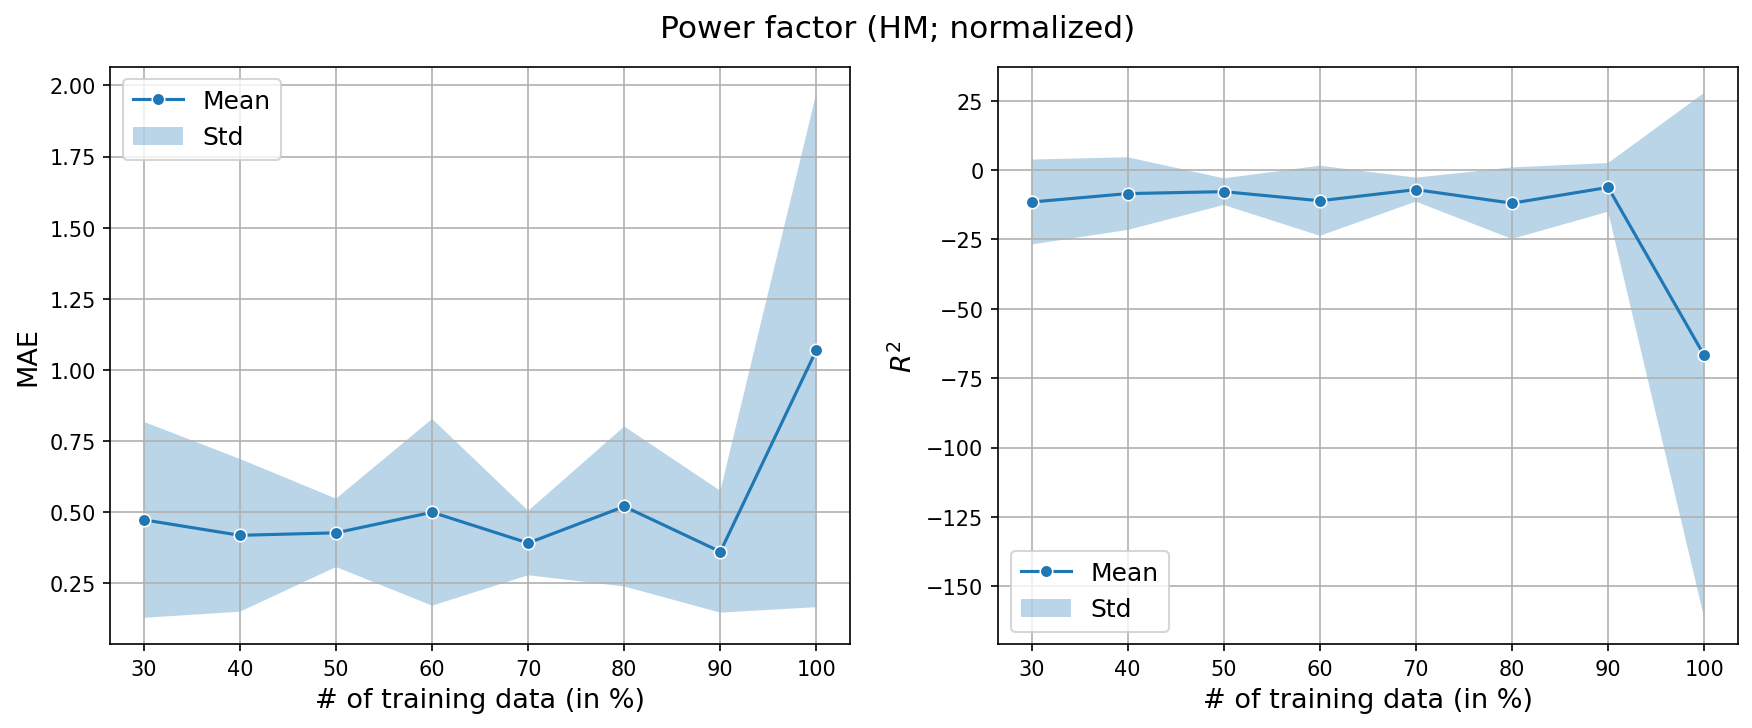

Processing property: Seebeck coefficient
Total metrics collected: 1 for Seebeck coefficient so far with ratio 0.9 and trial 1
Total metrics collected: 2 for Seebeck coefficient so far with ratio 0.9 and trial 2
Total metrics collected: 3 for Seebeck coefficient so far with ratio 0.9 and trial 3
Total metrics collected: 4 for Seebeck coefficient so far with ratio 0.9 and trial 4
Total metrics collected: 5 for Seebeck coefficient so far with ratio 0.9 and trial 5
Total metrics collected: 6 for Seebeck coefficient so far with ratio 0.9 and trial 6
Total metrics collected: 7 for Seebeck coefficient so far with ratio 0.9 and trial 7
Total metrics collected: 8 for Seebeck coefficient so far with ratio 0.9 and trial 8
Total metrics collected: 9 for Seebeck coefficient so far with ratio 0.9 and trial 9
Total metrics collected: 10 for Seebeck coefficient so far with ratio 0.9 and trial 10
Total metrics collected: 11 for Seebeck coefficient so far with ratio 0.9 and trial 11
Total metrics collec

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, 'MAE')

<Axes: xlabel='ratio'>

Text(0.5, 0, '# of training data (in %)')

Text(0, 0.5, '$R^2$')

Text(0.5, 0.95, 'Seebeck coefficient (HM; normalized)')

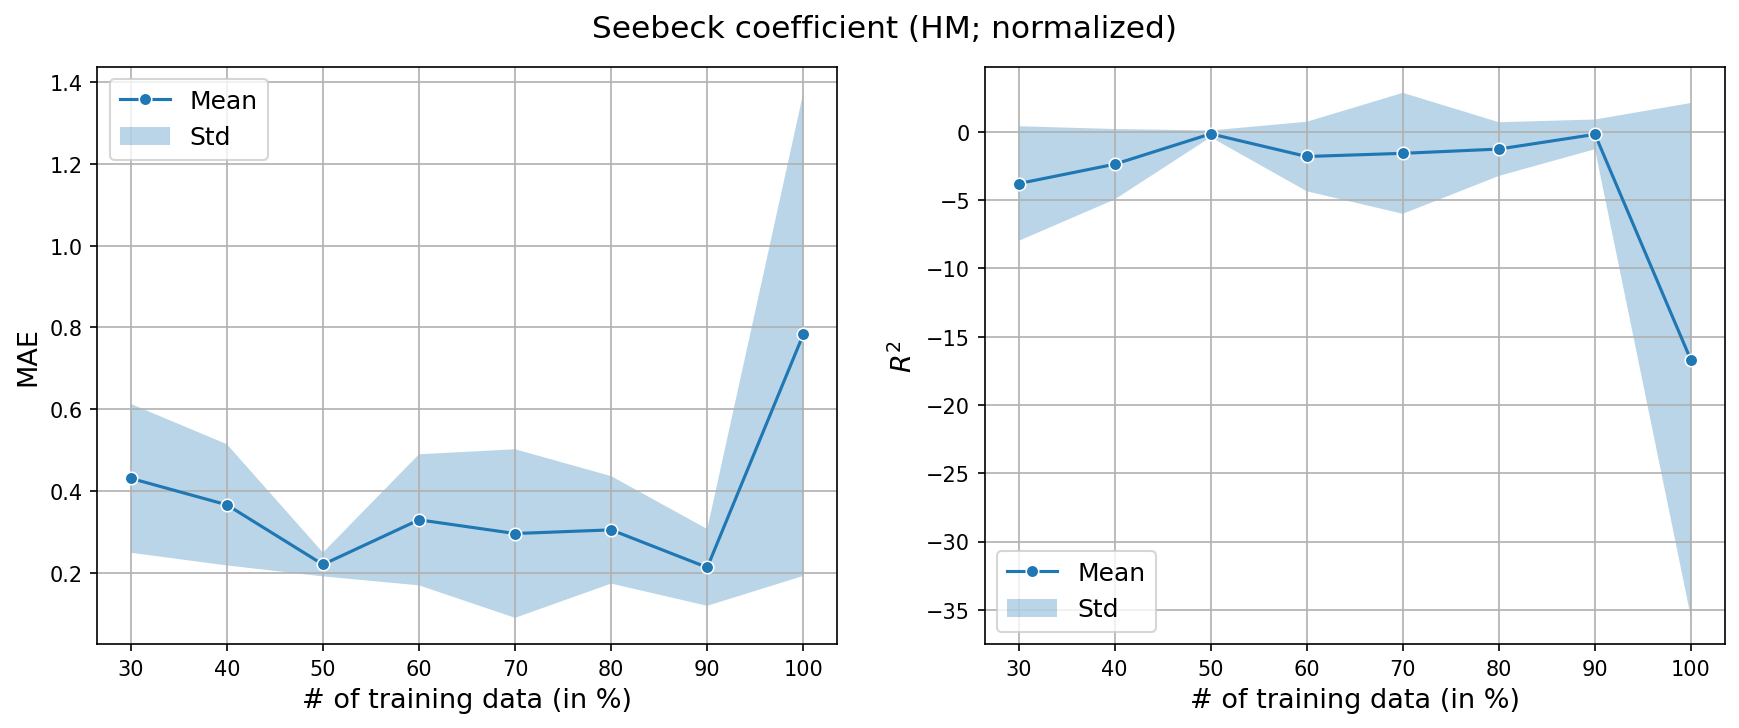

Processing property: ZT
No metrics found for ZT, skipping...


In [8]:
for prop_name in props:
    print(f"Processing property: {prop_name}")

    # 定义 prediction 文件夹路径
    prediction_dir = Path(f"notebooks/logs/kernel_regression/{prop_name}")

    # # 用于存储所有 trial 的 metrics
    metrics_list = []

    for result_dir in prediction_dir.iterdir():
        if result_dir.is_dir() and result_dir.name not in [".ipynb_checkpoints", "summary"]:
            nk, ratio = result_dir.name.split("_")[-2:]
            nk, ratio = int(nk[2:]), float(ratio[1:])
            for pred_dir in (result_dir / "predictions").iterdir():
                if pred_dir.is_dir() and pred_dir.name.startswith("trial_"):
                    n_trial = int(pred_dir.name.split("_")[-1])
                    metrics_path = pred_dir / "hm_metrics.json"
                    if metrics_path.exists():
                        with open(metrics_path, "r") as f:
                            metrics = json.load(f)
                            # print(f"Metrics for {result_dir.name}: {metrics}")
                        metrics.update({"nk": nk, "ratio": ratio, "trial": n_trial})
                        metrics_list.append(metrics)
                        print(
                            f"Total metrics collected: {len(metrics_list)} for {prop_name} so far with ratio {ratio} and trial {n_trial}"
                        )

    if len(metrics_list) == 0:
        print(f"No metrics found for {prop_name}, skipping...")
        continue

    # # 整理成 DataFrame
    df_metrics = pd.DataFrame(metrics_list).sort_values(by=["ratio", "trial"])
    df_metrics = df_metrics[df_metrics["ratio"] >= 0.3]

    grouped = df_metrics.groupby("ratio")[["mae", "r2"]]
    mean_mae = grouped.mean()
    std_mae = grouped.std()

    percent_index = mean_mae.index * 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    plt.subplots_adjust(wspace=0.2)
    sns.lineplot(x=percent_index, y=mean_mae["mae"].values, marker="o", ax=ax1, label="Mean")
    ax1.fill_between(
        percent_index,
        mean_mae["mae"].values - std_mae["mae"].values,
        mean_mae["mae"].values + std_mae["mae"].values,
        alpha=0.3,
        label="Std",
    )
    ax1.set_xlabel("# of training data (in %)", fontsize=13)
    ax1.set_ylabel("MAE", fontsize=13)
    # ax1.set_title(f"{prop_name}", fontsize=13)
    ax1.legend(fontsize=12)
    ax1.grid(True)

    sns.lineplot(x=percent_index, y=mean_mae["r2"].values, marker="o", ax=ax2, label="Mean")
    ax2.fill_between(
        percent_index,
        mean_mae["r2"].values - std_mae["r2"].values,
        mean_mae["r2"].values + std_mae["r2"].values,
        alpha=0.3,
        label="Std",
    )
    ax2.set_xlabel("# of training data (in %)", fontsize=13)
    ax2.set_ylabel(r"$R^2$", fontsize=13)
    # ax2.set_title(f"{prop_name} (normalized)", fontsize=13)
    ax2.legend(fontsize=12)
    ax2.grid(True)
    fig.suptitle(f"{prop_name} (HM; normalized)", fontsize=15, y=0.95)

    # 保存df_metrics为csv和parquet格式
    summary_dir = prediction_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    df_metrics.to_csv(summary_dir / "hm_df_metrics.csv", index=False)
    df_metrics.to_parquet(summary_dir / "hm_df_metrics.parquet", index=False)

    # 保存fig为png格式
    fig.savefig(summary_dir / "hm_metrics_plot.png", bbox_inches="tight", dpi=200)

    plt.show()